In [2]:
import os
import joblib
import numpy as np
import pandas as pd
import xgboost as xgb
import re
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import (
    accuracy_score, classification_report, roc_auc_score, log_loss,
    balanced_accuracy_score, cohen_kappa_score
)
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.calibration import CalibratedClassifierCV

# Load and Preprocess Data
def load_and_preprocess(directory, label=None):
    data_frames = []
    for file in os.listdir(directory):
        if file.endswith(".csv"):
            df = pd.read_csv(os.path.join(directory, file))
            if label is not None:
                df["Label"] = label  # Assign class labels
            # Extract subject ID from filename (e.g., sub-88000489)
            match = re.search(r"(sub-\d+)", file)
            df["subject_id"] = match.group(1) if match else "unknown"
            data_frames.append(df)

    df = pd.concat(data_frames, ignore_index=True)
    
    # Encode categorical columns except subject_id
    for col in df.select_dtypes(include=['object']).columns:
        if col != "subject_id":
            df[col] = LabelEncoder().fit_transform(df[col])
    
    # Handle missing values ONLY for numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

    return df


# Load Data
dataset_path_healthy = "/mnt/data/saikrishna/Team_4/preprocessed_data_new/healthy"
dataset_path_mdd = "/mnt/data/saikrishna/Team_4/preprocessed_data_new/mdd"

df_healthy = load_and_preprocess(dataset_path_healthy, label=0)
df_mdd = load_and_preprocess(dataset_path_mdd, label=1)

df = pd.concat([df_healthy, df_mdd], axis=0).reset_index(drop=True)

# Subject-level Split
unique_subjects = df["subject_id"].unique()
train_ids, test_ids = train_test_split(unique_subjects, test_size=0.2, random_state=42, stratify=None)
val_ids, test_ids = train_test_split(test_ids, test_size=0.5, random_state=42)

train_df = df[df["subject_id"].isin(train_ids)]
val_df = df[df["subject_id"].isin(val_ids)]
test_df = df[df["subject_id"].isin(test_ids)]

# Drop subject ID
X_train = train_df.drop(columns=["Label", "subject_id"]).values
y_train = train_df["Label"].values

original_feature_names = train_df.drop(columns=["Label", "subject_id"]).columns.tolist()
joblib.dump(original_feature_names, "original_feature_names.pkl")

X_val = val_df.drop(columns=["Label", "subject_id"]).values
y_val = val_df["Label"].values

X_test = test_df.drop(columns=["Label", "subject_id"]).values
y_test = test_df["Label"].values

# Scale data
scaler = MinMaxScaler(feature_range=(0, 100))
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
joblib.dump(scaler, "best_xgb_scaler.pkl")

# Define XGBoost Model
xgb_model = xgb.XGBClassifier(
    objective="binary:logistic",
    tree_method="hist",
    device="cuda",
    eval_metric="logloss",
    learning_rate=0.005,
    max_depth=25,
    gamma=0.2,
    subsample=0.95,
    colsample_bytree=0.97,
    min_child_weight=1,
    reg_alpha=0.8,
    reg_lambda=3.0,
    n_estimators=6000,
    verbosity=1
)

# Calibrated Model
calibrated_model = CalibratedClassifierCV(estimator=xgb_model, method='sigmoid', cv=3)
calibrated_model.fit(X_train_scaled, y_train)
joblib.dump(calibrated_model, "best_xgb_calibrated_model.pkl")

# Cross-Validation (on train set)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)
cv_scores = cross_val_score(xgb_model, X_train_scaled, y_train, cv=cv, scoring="accuracy")

# Train original model for evaluation
xgb_model.fit(X_train_scaled, y_train)
joblib.dump(xgb_model, "best_xgb_model.pkl")

# Evaluate on Validation Set
val_preds = xgb_model.predict(X_val_scaled)
val_probs = xgb_model.predict_proba(X_val_scaled)[:, 1]

accuracy = accuracy_score(y_val, val_preds)
roc_auc = roc_auc_score(y_val, val_probs)
logloss_val = log_loss(y_val, val_probs)
balanced_acc = balanced_accuracy_score(y_val, val_preds)
kappa = cohen_kappa_score(y_val, val_preds)
report = classification_report(y_val, val_preds)

# Print Results
print(f"\nValidation Accuracy: {accuracy:.4f}")
print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")
print(f"Log Loss: {logloss_val:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("\nClassification Report:\n", report)
print(f"Cross-Validation Accuracy Scores: {cv_scores}")



Validation Accuracy: 0.9167
Balanced Accuracy: 0.9000
Cohen's Kappa: 0.8235
Log Loss: 0.4183
ROC AUC Score: 0.8714

Classification Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.93        14
           1       1.00      0.80      0.89        10

    accuracy                           0.92        24
   macro avg       0.94      0.90      0.91        24
weighted avg       0.93      0.92      0.91        24

Cross-Validation Accuracy Scores: [0.74285714 0.82857143 0.76470588 0.79411765 0.76470588]


# ALL models

In [3]:
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV

# Define and calibrate SVM model
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True)
calibrated_svm = CalibratedClassifierCV(estimator=svm_model, method='sigmoid', cv=3)
calibrated_svm.fit(X_train_scaled, y_train)
joblib.dump(calibrated_svm, "best_svm_calibrated_model.pkl")

# Predict and Evaluate on Validation Set
svm_val_preds = calibrated_svm.predict(X_val_scaled)
svm_val_probs = calibrated_svm.predict_proba(X_val_scaled)[:, 1]

# Evaluation Metrics for SVM
svm_accuracy = accuracy_score(y_val, svm_val_preds)
svm_roc_auc = roc_auc_score(y_val, svm_val_probs)
svm_logloss = log_loss(y_val, svm_val_probs)
svm_balanced_acc = balanced_accuracy_score(y_val, svm_val_preds)
svm_kappa = cohen_kappa_score(y_val, svm_val_preds)
svm_report = classification_report(y_val, svm_val_preds)

# Print SVM Results
print("\n--- SVM Model Evaluation ---")
print(f"Validation Accuracy: {svm_accuracy:.4f}")
print(f"Balanced Accuracy: {svm_balanced_acc:.4f}")
print(f"Cohen's Kappa: {svm_kappa:.4f}")
print(f"Log Loss: {svm_logloss:.4f}")
print(f"ROC AUC Score: {svm_roc_auc:.4f}")
print("\nClassification Report:\n", svm_report)



--- SVM Model Evaluation ---
Validation Accuracy: 0.6667
Balanced Accuracy: 0.6714
Cohen's Kappa: 0.3333
Log Loss: 0.6288
ROC AUC Score: 0.7000

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.64      0.69        14
           1       0.58      0.70      0.64        10

    accuracy                           0.67        24
   macro avg       0.67      0.67      0.66        24
weighted avg       0.68      0.67      0.67        24



In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, cohen_kappa_score,
    log_loss, roc_auc_score, classification_report
)

models = {
    "RandomForest": RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

results = {}

for name, model in models.items():
    
    # Calibrate for probability output
    calibrated_model = CalibratedClassifierCV(model, method="sigmoid", cv=3)
    calibrated_model.fit(X_train_scaled, y_train)
    joblib.dump(calibrated_model, f"model_{name.lower()}_calibrated.pkl")

    val_preds = calibrated_model.predict(X_val_scaled)
    val_probs = calibrated_model.predict_proba(X_val_scaled)[:, 1]

    results[name] = {
        "Accuracy": accuracy_score(y_val, val_preds),
        "Balanced Accuracy": balanced_accuracy_score(y_val, val_preds),
        "ROC AUC": roc_auc_score(y_val, val_probs),
        "Classification Report": classification_report(y_val, val_preds)
    }

# 🧾 Print Summary Table
print("\n🧠 Model Comparison Results:")
for model_name, metrics in results.items():
    print(f"\n📌 {model_name}")
    for metric, value in metrics.items():
        if metric != "Classification Report":
            print(f"{metric}: {value:.4f}")
    print("\n" + metrics["Classification Report"])



🧠 Model Comparison Results:

📌 RandomForest
Accuracy: 0.8333
Balanced Accuracy: 0.8286
ROC AUC: 0.9143

              precision    recall  f1-score   support

           0       0.86      0.86      0.86        14
           1       0.80      0.80      0.80        10

    accuracy                           0.83        24
   macro avg       0.83      0.83      0.83        24
weighted avg       0.83      0.83      0.83        24


📌 LogisticRegression
Accuracy: 0.6250
Balanced Accuracy: 0.6357
ROC AUC: 0.7571

              precision    recall  f1-score   support

           0       0.73      0.57      0.64        14
           1       0.54      0.70      0.61        10

    accuracy                           0.62        24
   macro avg       0.63      0.64      0.62        24
weighted avg       0.65      0.62      0.63        24


📌 KNN
Accuracy: 0.3333
Balanced Accuracy: 0.3857
ROC AUC: 0.5107

              precision    recall  f1-score   support

           0       0.25      0.07    

# Shap

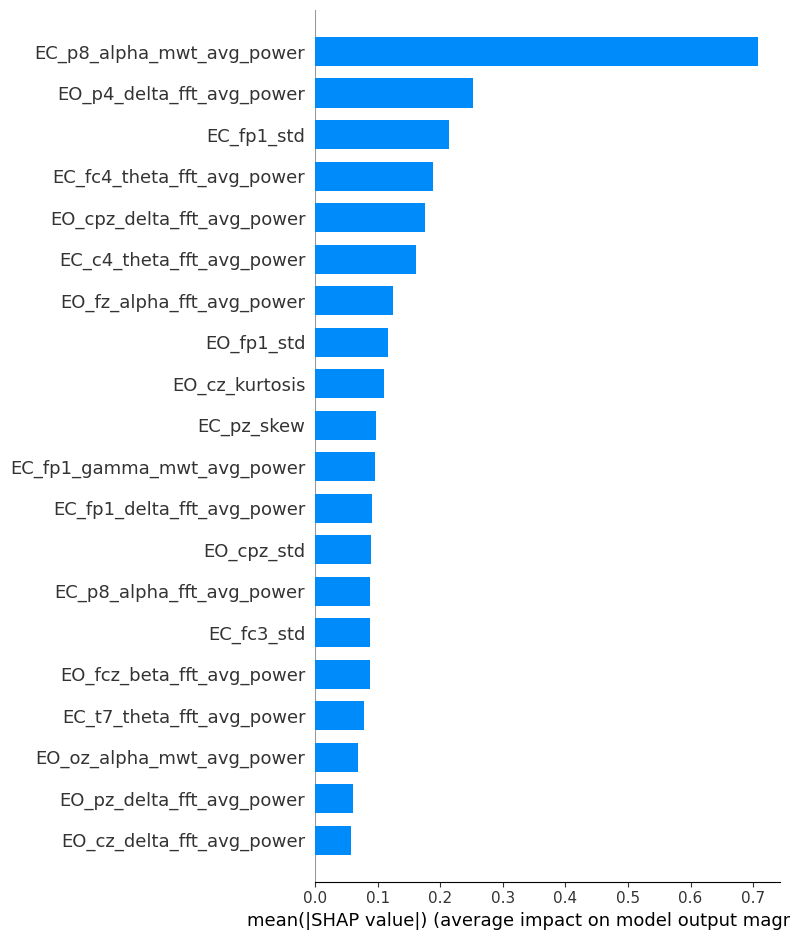

In [8]:
import shap
import matplotlib.pyplot as plt

# SHAP explainer using TreeExplainer (optimized for tree-based models like XGBoost)
explainer = shap.Explainer(model, X_train_scaled, feature_names=original_feature_names)

# Explain the validation set
shap_values = explainer(X_val_scaled)

# === SHAP Plots ===

# 1. Summary Bar Plot: Shows top contributing features across the dataset
shap.summary_plot(shap_values, X_val_scaled, feature_names=original_feature_names, plot_type="bar")

# 2. Optional: Beeswarm Plot (shows distribution of impact)
# shap.summary_plot(shap_values, X_val_scaled, feature_names=original_feature_names)


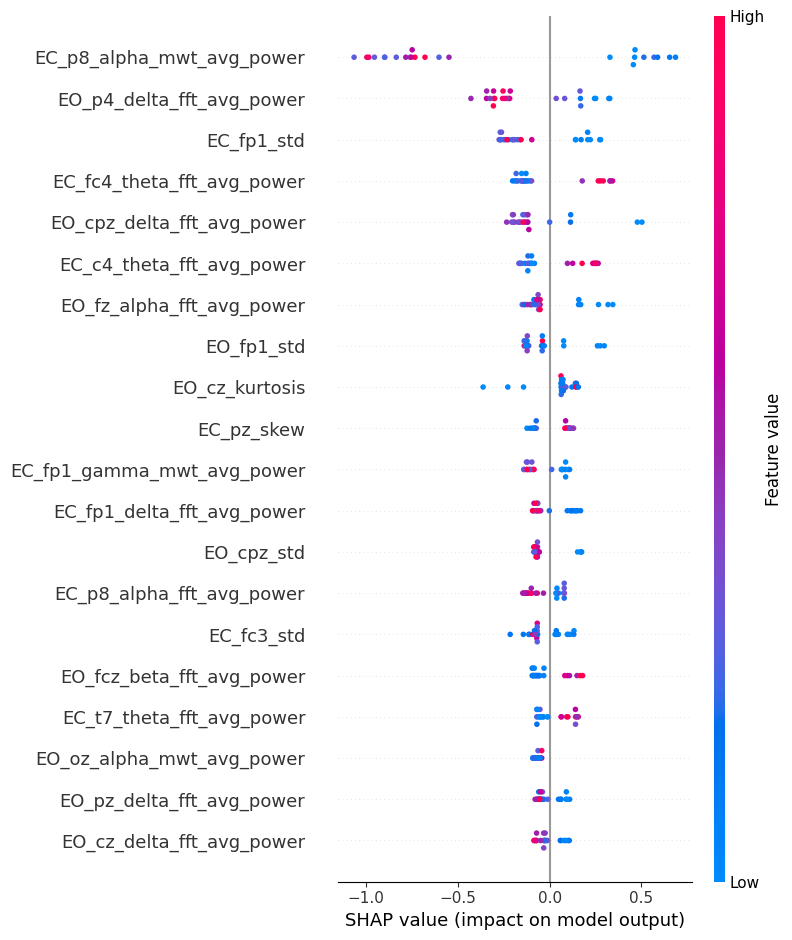

In [11]:
# SHAP summary scatter plot (visualizes feature importance and distribution of feature impact)
shap.summary_plot(shap_values, X_val_scaled, feature_names=original_feature_names, plot_type="dot")
